<a href="https://colab.research.google.com/github/orca3/llm-model-serving/blob/main/ch02/workthrough_LLM_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet transformers tiktoken transformers_stream_generator bertviz

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.1 MB/s eta 0:00:00
   ━

In [2]:
import torch
import gc
import time

# Unload models and clean up gpu memory cache
def free_gpu(model):
  if model:
    # Removes the reference to the model's memory,
    # making it eligible for garbage collection.
    del model

  # Release any cached GPU memory that's no longer needed.
  torch.cuda.empty_cache()

  # Trigger garbage collection to ensure memory is fully released.
  gc.collect()


Run LLM with HuggingFace library

In [ ]:

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Initialize the text generation pipeline
generator = pipeline('text-generation', model='Qwen/Qwen2.5-0.5B')

# Define your prompt
prompt = "Write a short introduction about US capital city."

# Generate text
generated_text = generator(prompt, max_length=50, num_return_sequences=1)

# Print the generated text
print(generated_text[0]['generated_text'])

free_gpu(generator.model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=2048) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Write a short introduction about US capital city. The United States of America is the largest country in the world by area, with a total land area of approximately 9.8 million square kilometers. The capital city of the United States is Washington, D.C., which is located in the Mid-Atlantic region of the country. Washington, D.C. is the seat of the United States government and is home to the White House, the United States Capitol, and the United States Supreme Court. The city is also home to many other important institutions, including the National Mall, the White House Museum, and the National Archives.


Let's break it up the generator function to examine step by step.

In [20]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

first_token_generated = False

# (1) Specify the model and load tokenizer and model
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda" if torch.cuda.is_available() else "cpu")

# (2) Define the input prompt - a text about communication history
prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

# (3) Convert (Tokenize) prompt to the input format that model understands
max_new_tokens = 100
# tokenize the input prompt for the first output token
# PS: prompt is the initial input sequence for LLM generation
idx = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
start_time = total_time = time.time()
times = []

# (4) Main generation loop - generate tokens one by one
for _ in range(max_new_tokens):

    # (A) Set the current context for generation
    idx_cond = idx
    with torch.no_grad():
        # (B) Generate predictions (token candidates) for next token
        outputs = model(idx_cond)
        # Get the logits (raw prediction scores) for each token predictions
        logits = outputs.logits

    # (C) Select next token from the predictions generated in step (B)
    logits = logits[:, -1, :] #  Select only the logits for the last token
    probas = torch.softmax(logits, dim=-1) # Convert logits to probabilities using softmax
    # Sample the next token from the probability distribution of the predicted tokens from step (B)
    idx_next = torch.multinomial(probas, num_samples=1)
    print("Next Token is:", tokenizer.decode(idx_next[0], skip_special_tokens=True))
    time_cost = time.time() - start_time
    times.append(time_cost)

    # Track time spent in token generation
    if not first_token_generated:
        print(f"Time taken for generating the first token: {time_cost:.4f} seconds")
        first_token_generated = True
    else:
        print(f"Time taken for generating a token: {time_cost:.4f} seconds")

    start_time = time.time()

    # (D) Append the new token to the input sequence
    idx = torch.cat((idx, idx_next), dim=1)

    # (E) Check if end-of-sequence token was generated
    if idx_next.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

# Decode the entire generated sequence
generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

# Free GPU memory
free_gpu(model=model)

Next Token is:  The
Time taken for generating the first token: 0.1056 seconds
Next Token is:  answer
Time taken for generating a token: 0.0955 seconds
Next Token is:  to
Time taken for generating a token: 0.0852 seconds
Next Token is:  this
Time taken for generating a token: 0.0741 seconds
Next Token is:  question
Time taken for generating a token: 0.0721 seconds
Next Token is:  will
Time taken for generating a token: 0.0745 seconds
Next Token is:  likely
Time taken for generating a token: 0.0754 seconds
Next Token is:  be
Time taken for generating a token: 0.0730 seconds
Next Token is:  multif
Time taken for generating a token: 0.0755 seconds
Next Token is: ac
Time taken for generating a token: 0.0759 seconds
Next Token is: eted
Time taken for generating a token: 0.0728 seconds
Next Token is:  and
Time taken for generating a token: 0.0741 seconds
Next Token is:  multid
Time taken for generating a token: 0.0766 seconds
Next Token is: imensional
Time taken for generating a token: 0.0729

Display the generation time taken for each token

Text(0.5, 1.0, 'LLM Generation Times for each token')

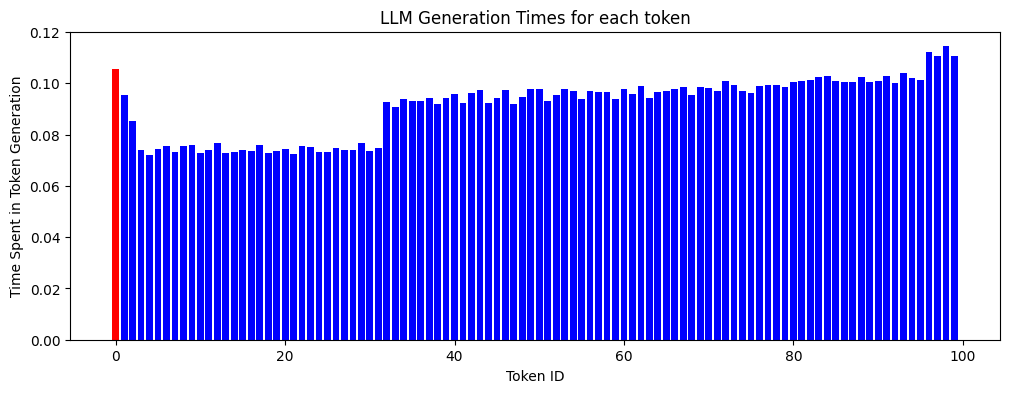

In [22]:
import matplotlib.pyplot as plt

# First chart: First bar red, others blue
plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
plt.bar(range(len(times)), times, color=['red'] + ['blue'] * (len(times) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times for each token")

# # Second chart: Exclude the first element
# plt.subplot(1, 2, 2)
# plt.bar(range(len(times) - 1), times[1:])
# plt.xlabel("Token ID")
# plt.ylabel("Time Spent in Token Generation")
# plt.title("Token Generation Times (Excluded the initial prompt tokens)")

# plt.tight_layout()
# plt.show()


In [26]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, use_cache=True) \
            .to("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to("cuda" if torch.cuda.is_available() else "cpu")

prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

num_interations = 100
times_with_cache = []

first_token_generated = False
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
idx = input_ids
start_time = total_time = time.time()

# (1) Define Key/Value Cache for faster generation
past_key_values = None

for _ in range(num_interations):
    print("input_ids size: " + str(input_ids.size()))
    with torch.no_grad():
        outputs = model(input_ids=input_ids,
          past_key_values=past_key_values, # (2) Use KV-cache from previous iteration
          use_cache=True, # (2) Enable KV caching
          max_new_tokens = 100,
          min_new_tokens= 100)


        logits = outputs.logits
        # (3) Update KV Cache
        past_key_values = outputs.past_key_values
        torch.cuda.synchronize()

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    generated_token_id = torch.multinomial(probas, num_samples=1) # Sample instead of argmax

    # (4) Update input_ids with only the new token (using KV-cache)
    input_ids = generated_token_id  # Note: Not concatenating with previous tokens due to KV-cache

    print("Next token:", tokenizer.decode(generated_token_id[0], skip_special_tokens=True))
    idx = torch.cat((idx, generated_token_id), dim=1)

    time_cost= time.time() - start_time
    times_with_cache.append(time_cost)
    if not first_token_generated:
        print(f"Time take for first token: {time_cost:.4f} seconds")
        first_token_generated = True
    else:
        print(f"Time take for next token: {time_cost:.4f} seconds")
    start_time = time.time()

    if generated_token_id.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

free_gpu(model=model)


input_ids size: torch.Size([1, 225])
Next token:  Can
Time take for first token: 0.1181 seconds
input_ids size: torch.Size([1, 1])
Next token:  we
Time take for next token: 0.0299 seconds
input_ids size: torch.Size([1, 1])
Next token:  look
Time take for next token: 0.0315 seconds
input_ids size: torch.Size([1, 1])
Next token:  towards
Time take for next token: 0.0315 seconds
input_ids size: torch.Size([1, 1])
Next token:  these
Time take for next token: 0.0293 seconds
input_ids size: torch.Size([1, 1])
Next token:  advancements
Time take for next token: 0.0290 seconds
input_ids size: torch.Size([1, 1])
Next token:  with
Time take for next token: 0.0289 seconds
input_ids size: torch.Size([1, 1])
Next token:  a
Time take for next token: 0.0292 seconds
input_ids size: torch.Size([1, 1])
Next token:  critical
Time take for next token: 0.0293 seconds
input_ids size: torch.Size([1, 1])
Next token:  eye
Time take for next token: 0.0316 seconds
input_ids size: torch.Size([1, 1])
Next token: ,

Show results

<Figure size 1200x800 with 0 Axes>

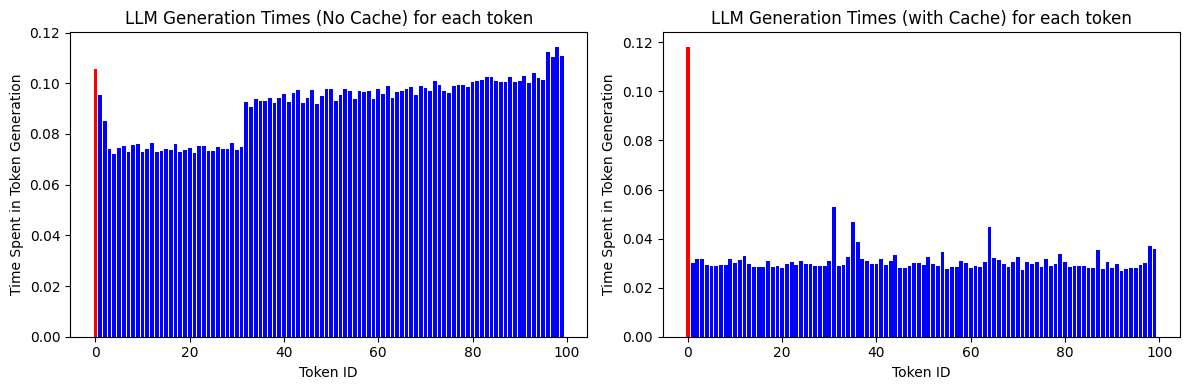

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Display the time cost of LLM token generation without KV Cache
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(times)), times, color=['red'] + ['blue'] * (len(times) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times (No Cache) for each token")


# Display the time cost of LLM token generation with KV Cache
plt.subplot(1, 2, 2)
plt.bar(range(len(times_with_cache)), times_with_cache, color=['red'] + ['blue'] * (len(times_with_cache) - 1))
plt.xlabel("Token ID")
plt.ylabel("Time Spent in Token Generation")
plt.title("LLM Generation Times (with Cache) for each token")

plt.tight_layout()
plt.show()


Show Context

Show how context impact generation

In [30]:
import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)\
          .to("cuda" if torch.cuda.is_available() else "cpu")

prompt = """The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of the telegraph, radio, and television further transformed how we connect with one another. But perhaps no advancement has reshaped communication more profoundly than the internet.
Today, digital platforms allow billions of people to share messages, media, and experiences in real time. Social media, messaging apps, and video conferencing have broken down geographical barriers and created new ways of building communities. At the same time, these technologies raise important questions about privacy, information overload, and the nature of human interaction.
Looking ahead, emerging technologies such as virtual reality, brain-computer interfaces, and artificial intelligence promise to once again redefine how we communicate. As we reflect on this history and anticipate the future, one question arises:

How might the next wave of communication tools shape our relationships, societies, and sense of identity?"""

max_new_tokens = 50
context_size = 2048 # Define the context size as needed for Qwen

first_token_generated = False
idx = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
start_time = total_time = time.time()

for _ in range(max_new_tokens):
    # (1) Take the latest "context_size" tokens as model input
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
        # generate candiates for the next token
        outputs = model(idx_cond)
        logits = outputs.logits

    # select next token from candidates based on probabilities.
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.multinomial(probas, num_samples=1)
    print("Decode text generated:", tokenizer.decode(idx_next[0], skip_special_tokens=True))

    idx = torch.cat((idx, idx_next), dim=1)

    if idx_next.item() == tokenizer.eos_token_id:
        print("\n[Generation completed - EOS token reached]")
        break

generated_text = tokenizer.decode(idx[0], skip_special_tokens=True)
print(f"Total time take for next token: {time.time() - total_time:.4f} seconds")
print(generated_text)

# Free GPU memory
free_gpu(model=model)

Decode text generated:  What
Decode text generated:  new
Decode text generated:  forms
Decode text generated:  of
Decode text generated:  human
Decode text generated:  connection
Decode text generated:  and
Decode text generated:  inter
Decode text generated: ection
Decode text generated:  will
Decode text generated:  emerge
Decode text generated:  from
Decode text generated:  these
Decode text generated:  technological
Decode text generated:  advancements
Decode text generated: ?
Decode text generated: 

[Generation completed - EOS token reached]
Total time take for next token: 1.3343 seconds
The history of human communication is a story of innovation. From ancient cave paintings and spoken language to the invention of writing systems, humans have constantly developed new methods to express ideas and share knowledge. The printing press revolutionized the spread of information, enabling books to be produced and distributed at an unprecedented scale. Centuries later, the invention of th